**Wine Quality Dataset**

https://www.kaggle.com/datasets/yasserh/wine-quality-dataset

**План:**

- EDA
- Попробовать модели 
    - SGDClassifier
    - DecisionTree
    - RandomForest
    - XGBClassifier

- Датасет несбалансированный, применить методы Oversampling
- Улучшить обучение кросс-валидацией
- Посмотреть важность признаков
- Подвести итоги и сравнить результаты

## EDA

In [ ]:
!pip install -q shap

     |████████████████████████████████| 575 kB 4.2 MB/s 


In [ ]:
from collections import defaultdict

import pandas as pd
import numpy as np

import missingno as mn # для просмотра пропущенных значений
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score, 
    log_loss, 
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold, 
    GridSearchCV, 
    cross_val_predict
)

import shap

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import TomekLinks 

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


Набор данных о качестве вина:

Набор данных описывает количество различных химических веществ, присутствующих в вине и их влияние на его качество.

Датасет одержит следующие столбцы:

- 1 - fixed acidity
- 2 - volatile acidity
- 3 - citric acid
- 4 - residual sugar
- 5 - chlorides
- 6 - free sulfur dioxide
- 7 - total sulfur dioxide
- 8 - density
- 9 - pH
- 10- sulphates
- 11 - alcohol
- 12 - quality

In [ ]:
df = pd.read_csv("WineQT.csv")
print(df.shape)
df.head()


(1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


Переименуем колонки для удобства

In [ ]:
colnames = {
    "alcohol": "алкоголь",
    "total sulfur dioxide": "диоксид серы",
    "residual sugar": "остаточный сахар",
    "sulphates": "сульфаты",
    "volatile acidity": "летучая кислотность",
    "chlorides": "хлориды",
    "density": "плотность",
    "fixed acidity": "фиксированная кислотность",
    "free sulfur dioxide": "оксид серы",
    "pH": "pH",
    "citric acid": "лимонная кислота",
}
df.rename(columns=colnames, inplace=True)
df.head()


In [ ]:
# Statistics for each column
display(df.isna().sum().sort_values(ascending=False), 
        df.describe())

фиксированная кислотность    0
летучая кислотность          0
лимонная кислота             0
остаточный сахар             0
хлориды                      0
оксид серы                   0
диоксид серы                 0
плотность                    0
pH                           0
сульфаты                     0
алкоголь                     0
quality                      0
Id                           0
dtype: int64

,фиксированная кислотность,летучая кислотность,лимонная кислота,остаточный сахар,хлориды,оксид серы,диоксид серы,плотность,pH,сульфаты,алкоголь,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


Напишем функцию для поиска возможных категориальных признаков

In [ ]:
def find_probable_cat(data, ignore_cols=[]):
    """
    Функция для поиска категориальных признаков
    """
    rows = defaultdict(lambda: defaultdict(list))
    for name in data.columns:
        if data[name].nunique() > 10 and not isinstance(data[name].iloc[0], str):
            continue
        
        rows["data"]["feature"].append(name)
        rows["data"]["type"].append("str" if isinstance(data[name].iloc[0], str) else "")
        rows["data"]["nunique"].append(data[name].nunique())
        rows["data"]["value_counts"].append(str(data[name].value_counts().to_dict()))
        rows["data"]["nans"].append(round(data[name].isna().mean(), 2))
    
    res = pd.DataFrame(rows["data"])
    return res[~res.feature.isin(ignore_cols)]

In [ ]:
%%time
cat_df = find_probable_cat(df)
cat_df

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 17.7 ms


,feature,type,nunique,value_counts,nans
0,quality,,6,"{5: 483, 6: 462, 7: 143, 4: 33, 8: 16, 3: 6}",0.0


Как видим, **все признаки числовые**. 
Значит не нужно предобрабатывать категориальные признаки переводом их в числовые

Посмотрим на баланс классов

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

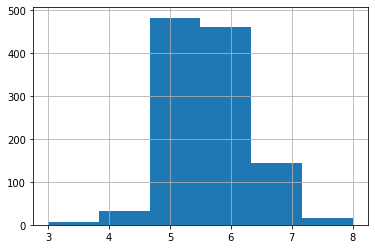

In [ ]:
display(df.quality.value_counts())

df.quality.hist(bins=6)
plt.show()

Видим, что **датасет несбалансированный**, больше всего средних значений **5** и **6**

Плохих (3,4) и хороших (7, 8) оценок мало $\approx$ 3%

0
0


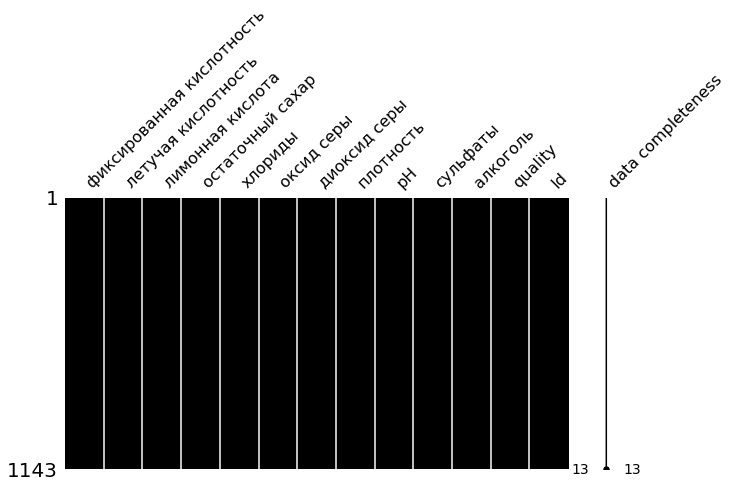

In [ ]:
print(df.isnull().sum().sum())
print(df.isna().sum().sum())

mn.matrix(
    df, 
    color=(0,0,0), 
    labels=True, 
    figsize=(10, 5)
)
plt.show()

In [ ]:
def missing_values_table(df):
    """Функция для поиска пропусков по каждой колонке"""
    # Общее число пропусков
    mis_val = df.isnull().sum()

    # Процент пропущенных значений
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Создадим таблицу с информацией о пропусках
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Переименуем колонки
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )

    # Отсортируем таблицу по числу пропусков (по убыванию)
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )

    # Напечатает информацию о пропусках
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )

    # Возвращаем итоговый датафрейм с информацией о пропусках
    return mis_val_table_ren_columns


In [ ]:
%%time
missing_values_table(df)

Your selected dataframe has 13 columns.
There are 0 columns that have missing values.
CPU times: user 14.6 ms, sys: 838 µs, total: 15.4 ms
Wall time: 50.4 ms


,Missing Values,% of Total Values


Пропущенных значений в данных нет - это хорошо

In [ ]:
df_tmp = df.drop("Id", axis=1)

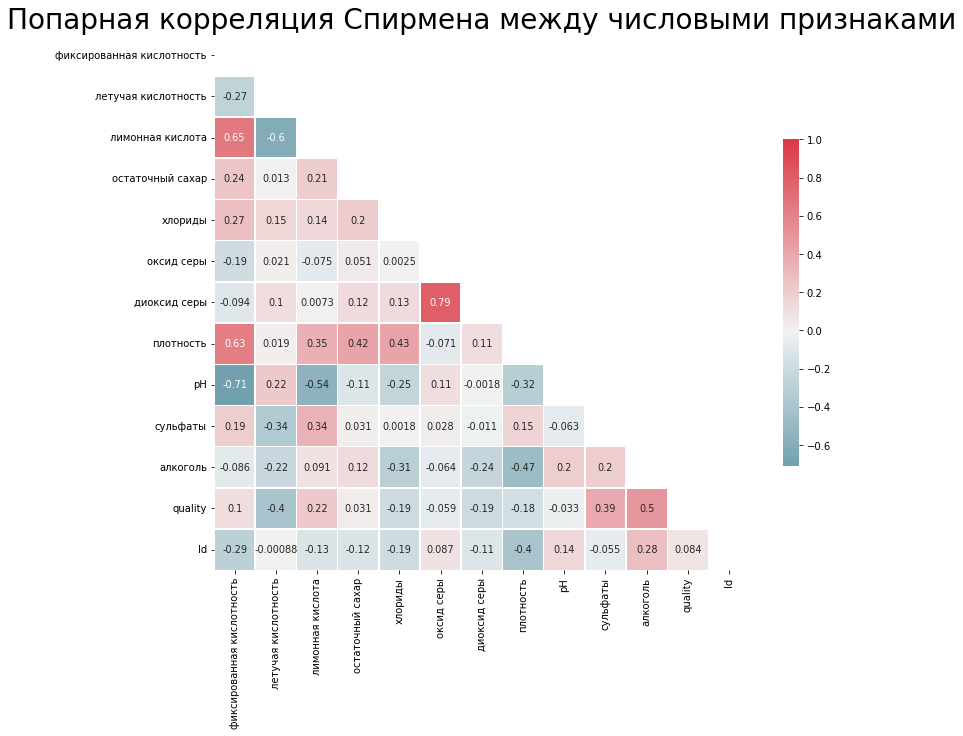

In [ ]:
corr = df.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(12, 12));

cmap = sns.diverging_palette(220, 10, as_cmap=True);

g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                annot_kws={"size": 35 / np.sqrt(len(corr))})
plt.title("Попарная корреляция Спирмена между числовыми признаками", fontsize=28)

plt.show()

- В целом признаки слабо скореллированы. 
- `Диоксид серы` и `оксид серы` скорреллированы наиболее сильно. Но значение корреляции не такое высокое, чтобы отбросить часть из низ.

Посмотрим на распределение колонок

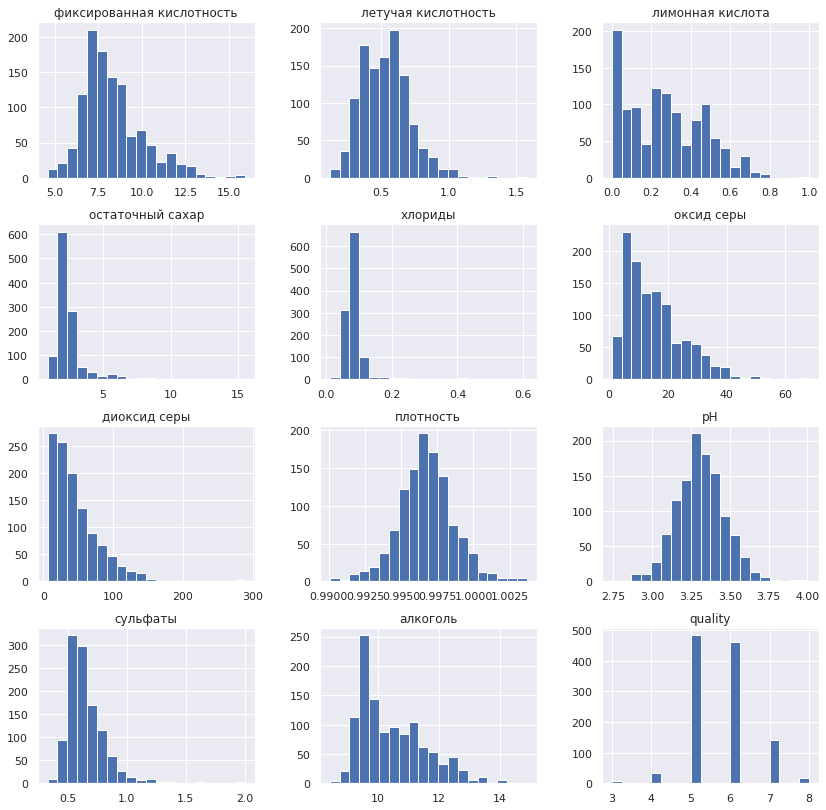

In [ ]:
sns.set()
df_tmp.hist(bins=20, figsize=(14,14))
plt.show()

## Learning

Подготовим таблицу с результатами испытаний

In [ ]:
rep_df = pd.DataFrame(columns=["Type", "Accuracy", "F1-score", "Log-Loss"])
rep_df2 = pd.DataFrame(columns=["DsType", "Model", "Accuracy", "F1-score", "Log-Loss"])

In [ ]:
# TRAIN-TEST
X = df_tmp.drop("quality", axis=1)
y = df_tmp["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)


In [ ]:
def draw_cm(y_test, y_preds):
    cm = confusion_matrix(y_test, y_preds)

    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=list(range(3,9)), yticklabels=list(range(3,9)))
    
    plt.ylabel("Real value")
    plt.xlabel("Predicted value")

    plt.show()


## Baseline :  SGDClassifier

- Масштабирование признаков
- SGDClassifier + LogLoss + scaler + GridSearchCV

SGDClassifier реализует обучение с помощью стохастического градиентного спуска, которая поддерживает различные функции потерь и штрафы за классификацию. По сути класс SGDClassifier представляет собой линейную модель SVM.

Преимуществами стохастического градиентного спуска являются:

- Эффективность.
- Простота реализации (множество возможностей для настройки кода).

К недостаткам стохастического градиентного спуска относятся:

- SGD чувствителен к масштабированию объектов.
- Очень шумный, т.к. градиент считается не по всему множеству объектов.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
sgd = SGDClassifier(random_state=1)
parameters_grid = {
    "loss": ["log"],  #'hinge'],
    "max_iter": [500, 1000, 5000],
    "penalty": ["l2", "l1"],
}
grid_cv = GridSearchCV(sgd, parameters_grid, cv=skf, scoring="neg_log_loss")
grid_cv.fit(X_train_scaled, y_train)
grid_cv.best_params_
# {'loss': 'log', 'max_iter': 500, 'penalty': 'l1'}


{'loss': 'log', 'max_iter': 500, 'penalty': 'l1'}

accuracy 0.5545851528384279
f1_score 0.2475690279945599
log_loss 1.1371835971731175


X has feature names, but SGDClassifier was fitted without feature names


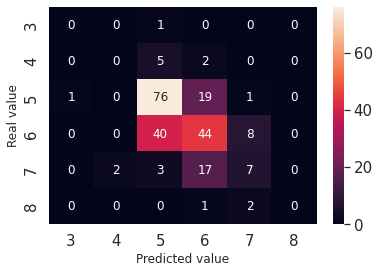

In [ ]:
best_params = grid_cv.best_params_

sgd = SGDClassifier(random_state=1, **best_params)
sgd.fit(X_train_scaled, y_train)
y_preds = sgd.predict(X_test_scaled)

print("accuracy", accuracy_score(y_test, y_preds))
print("f1_score", f1_score(y_test, y_preds, average="macro"))
print("log_loss", log_loss(y_test, sgd.predict_proba(X_test_scaled)))

rep_df.append(
    {
        "Type": "SGD+Scaler",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test_scaled)),
    },
    ignore_index=True,
)
rep_df2 = rep_df2.append(
    {
        "DsType": "Исходный",
        "Model": "SGD",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
draw_cm(y_test, y_preds)


In [ ]:
rep_df2

,DsType,Model,Accuracy,F1-score,Log-Loss
0,Исходный,SGD,0.554585,0.247569,7.37067


**Качество получилось довольно низкое. Accuracy и F1-score выглядят плохими**

## DecisionTreeClassifier

- DecisionTreeClassifier + GridSearchCV

Решающее дерево разбивает обучающую выборку на подмножества, в которых ответ более-менее очевиден.

**Построение решающего дерева:**

1. Фиксируем **критерий остановки обучения** и **критерий остановки разбиения**, а также **принцип выбора признака** и **порога для разбиения**.

2. **Начинаем с корня**, в нём — вся обучающая выборка.

3. Проверяем выборку по критерию остановки обучения и оцениваем точности построенного дерева.

4. **Перебираем признаки и пороги для всех вершин**, для которых не выполнен критерий остановки разбиения и для каждого выбираем лучшую пару (признак, порог) согласно зафиксированному принципу.

5. Для каждой зафиксированной пары (признак, порог) — разбиваем данные в вершине на две части так, чтобы объекты с значением выбранного признака меньше порога шли в левую вершину, а со значениями больше и равным порогу в правую.

6. Повторяем шаги 3-5, пока это возможно или пока это позволяет критерий остановки обучения.


**Области применения:**

- Банковское дело. Оценка кредитоспособности клиентов банка при выдаче кредитов.

- Промышленность. Контроль за качеством продукции (выявление дефектов), испытания без разрушений (например, проверка качества сварки) и т.д.

- Медицина. Диагностика заболеваний.

- Молекулярная биология. Анализ строения аминокислот.

- И многие другие области, где требуются **быстрые и интерпретируемые алгоритмы**!

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
dtc = DecisionTreeClassifier(random_state=1)

parameters_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [3, 5, 7, 9],
    "max_features": [6, 8, 10],
}
grid_cv = GridSearchCV(dtc, parameters_grid, cv=skf, scoring="neg_log_loss")
grid_cv.fit(X_train, y_train)
grid_cv.best_params_
# {'criterion': 'gini', 'max_depth': 3, 'max_features': 10, 'splitter': 'random'}


{'criterion': 'gini', 'max_depth': 3, 'max_features': 10, 'splitter': 'random'}

accuracy 0.5720524017467249
f1_score 0.27360548145581925
log_loss 7.370669529814241


X has feature names, but SGDClassifier was fitted without feature names
X has feature names, but SGDClassifier was fitted without feature names
X has feature names, but SGDClassifier was fitted without feature names


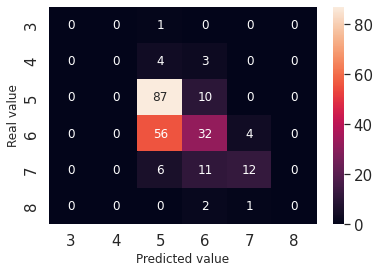

In [ ]:
best_params = grid_cv.best_params_

dtc = DecisionTreeClassifier(random_state=1, **best_params)
dtc.fit(X_train, y_train)
y_preds = dtc.predict(X_test)

print("accuracy", accuracy_score(y_test, y_preds))
print("f1_score", f1_score(y_test, y_preds, average="macro"))
print("log_loss", log_loss(y_test, sgd.predict_proba(X_test)))

rep_df = rep_df.append(
    {
        "Type": "DTC+GridCV",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)

rep_df2 = rep_df2.append(
    {
        "DsType": "Исходный",
        "Model": "DTC",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
draw_cm(y_test, y_preds)


## RandomForestClassifier

- RFC + GridSearchCV 
- Подбор гиперпараметров и обучение занимает ***15 min***

Random forest — это множество глубоких решающих деревьев.

В задаче регрессии их ответы усредняются, а в задаче
классификации принимается голосованием по большинству.

Поскольку у нас глубокие деревья, то у нас большой разброс, но маленькое смещение и ансамбль нам должны помочь уменьшить разброс.

Почему так? Достаточно вспомнить центральную предельную теорему!

В одной из постановок она говорит о том, что если мы усредним n одинаково распределенных случайных величин, то у получившейся случайной величины будет такое же математическое ожидание, а дисперсия уменьшится в n раз.

Но ведь ответ дерева – это тоже случайная величина и получается, что ответы от разных деревьев нужно сделать независимыми

**Решение 1:**

Выберем с повторением n объектов из исходной выборки (т.н. bootstrap).

Будем обучать дерево на том, что получилось. Это т.н. **bagging — bootstrap aggregating.**

**Решение 2:**

Для каждого дерева будем случайным образом отбирать m признаков ещё до его построения:

m = d/3 при регрессии и m = d^(1/2) при классификации.

Это называется **метод случайных подпространств**.

Таким образом, **Random Forest = Bagging + Random Subspaces Method**

**Итого общая идея Random Forest:** 

- Для каждого дерева создадим подвыборку объектов и признаков.

- Переобучим очень глубокие деревья на каждой подвыборке

- Агрегируем их предсказания.

- Чем слабее коррелируют предсказания деревьев, тем сильнее уменьшится variance.

- Bias же каждого дерева был изначально невелик. Если предсказания ещё и агрегировать, то он точно не сможет сильно вырасти.


**Смещение (bias)** — это погрешность оценки, возникающая в результате ошибочного предположения в алгоритме обучения. В результате большого смещения алгоритм может пропустить связь между признаками и выводом.

**Дисперсия (variance)** — это ошибка чувствительности к малым отклонениям в тренировочном наборе. При высокой дисперсии алгоритм может как-то трактовать случайный шум в тренировочном наборе, а не желаемый результат (переобучение).

In [ ]:
parameters = {
    "max_features": [6, 8, 12],
    "min_samples_leaf": [1, 3, 5],
    "max_depth": [8, 10, 12],
    "n_estimators": [100, 500, 1000],
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
rfc = RandomForestClassifier(n_estimators=50, random_state=1, n_jobs=-1)

gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf)
gcv.fit(X_train, y_train)
gcv.best_params_
# {'max_depth': 10,  'max_features': 8,  'min_samples_leaf': 1, 'n_estimators': 500}


accuracy 0.6681222707423581
f1_score 0.4014120832846145
log_loss 0.8478547989170016


X has feature names, but SGDClassifier was fitted without feature names
X has feature names, but SGDClassifier was fitted without feature names


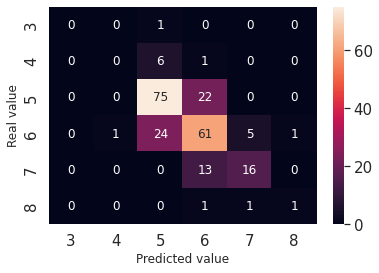

In [ ]:
# best_params = gcv.best_params_
best_params = {
    "max_depth": 10,
    "max_features": 8,
    "min_samples_leaf": 1,
    "n_estimators": 500,
}

rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train, y_train)
y_preds = rfc.predict(X_test)

print("accuracy", accuracy_score(y_test, y_preds))
print("f1_score", f1_score(y_test, y_preds, average="macro"))
print("log_loss", log_loss(y_test, rfc.predict_proba(X_test)))
rep_df = rep_df.append(
    {
        "Type": "RFC+GridCV",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
rep_df2 = rep_df2.append(
    {
        "DsType": "Исходный",
        "Model": "RFC",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
draw_cm(y_test, y_preds)


Качество чуть выше, однако всё равно низкое

##XGBClassifier

- XGBClassifier + GridSearchCV  5m47s


XGBoost – это библиотека градиентного бустинга.

In [ ]:
# max_depth learning_rate 0.1 n_estimators=100, objective='binary:logistic' booster='gbtree' gbtree, gblinear or dart.
parameters = {
    "max_depth": [3, 5, 7, 9, 15],
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [50, 100, 200, 500],
    "booster": ["gbtree", "gblinear"],
}
xgb = XGBClassifier(random_state=1)
gcv = GridSearchCV(xgb, parameters, n_jobs=-1, cv=skf)
gcv.fit(X_train, y_train)
gcv.best_params_
# {'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}


In [ ]:
# best_params = gcv.best_params_
best_params = {
    "booster": "gbtree",
    "learning_rate": 0.01,
    "max_depth": 9,
    "n_estimators": 200,
}
xgb = XGBClassifier(random_state=1, **best_params)
xgb.fit(X_train, y_train)
y_preds = xgb.predict(X_test)

print("accuracy", accuracy_score(y_test, y_preds))
print("f1_score", f1_score(y_test, y_preds, average="macro"))
print("log_loss", log_loss(y_test, xgb.predict_proba(X_test)))

rep_df = rep_df.append(
    {
        "Type": "XGB+GridCV",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
rep_df2 = rep_df2.append(
    {
        "DsType": "Исходный",
        "Model": "XGB",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)


accuracy 0.6419213973799127
f1_score 0.413265306122449
log_loss 0.9954284413282528


X has feature names, but SGDClassifier was fitted without feature names
X has feature names, but SGDClassifier was fitted without feature names


Получилось лучшее качество среди всех моделей. Accuracy и F1-score самые высокие

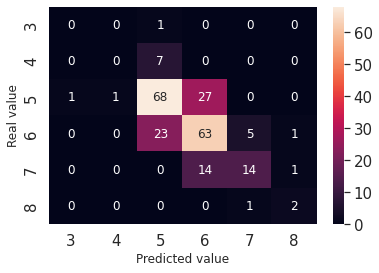

In [ ]:
draw_cm(y_test, y_preds)

Влияние показателей на качество, несбалансированные данные

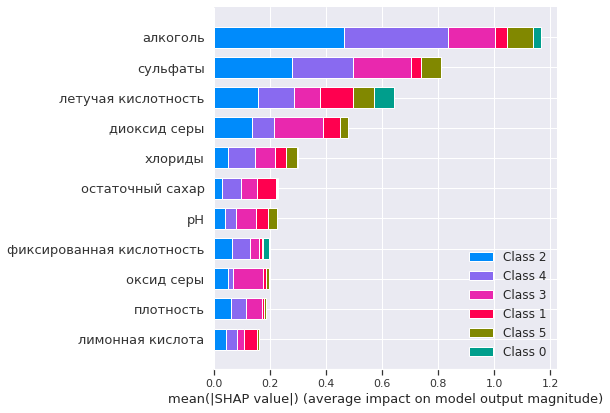

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=X_test, max_display=50, title='Feature importance')


Применим технику оверсэмплинга минорных классов для улучшения качества.
В общем случае oversampling представляет из себя технику расширения датасета засчет определённой стратегии сэмплирования классов. 

In [ ]:
y_train.value_counts()

5    386
6    370
7    114
4     26
8     13
3      5
Name: quality, dtype: int64

In [ ]:
y_test.value_counts()

5    97
6    92
7    29
4     7
8     3
3     1
Name: quality, dtype: int64

In [ ]:
#X, y 1143
#X_train 914
#sm = SMOTE(random_state=1, k_neighbors=4)
#6    386
#5    386
#7    386
#4    386
#8    386
#3    386
#sm = SMOTE(random_state=1, sampling_strategy='minority', k_neighbors=4)
#5    386
#3    386
#6    370
#7    114
#4     26
#8     13
sm = SMOTE(random_state=1, sampling_strategy={3:200, 4:200, 8:200}, k_neighbors=4)
#5    386
#6    370
#7    114
#4    100
#8    100
#3    100

X2_train, y2_train = sm.fit_resample(X_train, y_train)
y2_train.value_counts()

5    386
6    370
4    200
8    200
3    200
7    114
Name: quality, dtype: int64

In [ ]:
print(len(X_train))  #914
print(len(X_test))  #229
print(len(X2_train))  #1470

914
229
1470


## Сбалансированный датасет (V2)

accuracy 0.5021834061135371
f1_score 0.3084320910954191
log_loss 1.3440420640458959


X has feature names, but SGDClassifier was fitted without feature names


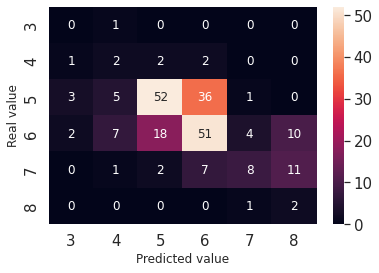

In [ ]:
# SGDClassifier
scaler = StandardScaler()
scaler.fit(X2_train, y2_train)
X2_train_scaled = scaler.transform(X2_train)
X2_test_scaled = scaler.transform(X_test)

sgd_params = {"loss": "log", "max_iter": 500, "penalty": "l1"}
sgd = SGDClassifier(random_state=1, loss="log")  # , **sgd_params)
sgd.fit(X2_train_scaled, y2_train)
y_preds = sgd.predict(X2_test_scaled)

print("accuracy", accuracy_score(y_test, y_preds))
print("f1_score", f1_score(y_test, y_preds, average="macro"))
print("log_loss", log_loss(y_test, sgd.predict_proba(X2_test_scaled)))

rep_df = rep_df.append(
    {
        "Type": "SGD2",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X2_test_scaled)),
    },
    ignore_index=True,
)
rep_df2 = rep_df2.append(
    {
        "DsType": "SMOTE",
        "Model": "SGD",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
draw_cm(y_test, y_preds)


In [ ]:
#repDf.drop(index=9, inplace=True)
rep_df2

,DsType,Model,Accuracy,F1-score,Log-Loss
0,Исходный,SGD,0.554585,0.247569,7.370670
1,Исходный,DTC,0.572052,0.273605,7.370670
2,Исходный,RFC,0.668122,0.401412,7.370670
3,Исходный,XGB,0.641921,0.413265,7.370670
4,SMOTE,SGD,0.502183,0.308432,2.557907


accuracy 0.5895196506550219
f1_score 0.39478672735619424
log_loss 14.177489000531025


X has feature names, but SGDClassifier was fitted without feature names
X has feature names, but SGDClassifier was fitted without feature names


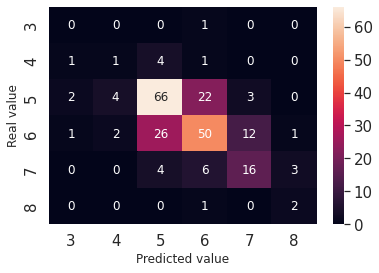

In [ ]:
# DecisionTreeClassifier
dtc_params = {
    "criterion": "gini",
    "max_depth": 3,
    "max_features": 10,
    "splitter": "random",
}
dtc = DecisionTreeClassifier(random_state=1)  # , **dtc_params)
dtc.fit(X2_train, y2_train)
y_preds = dtc.predict(X_test)

print("accuracy", accuracy_score(y_test, y_preds))
print("f1_score", f1_score(y_test, y_preds, average="macro"))
print("log_loss", log_loss(y_test, dtc.predict_proba(X_test)))

rep_df = rep_df.append(
    {
        "Type": "DTC2",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
rep_df2 = rep_df2.append(
    {
        "DsType": "SMOTE",
        "Model": "DTC",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
draw_cm(y_test, y_preds)


accuracy 0.6506550218340611
f1_score 0.40973883432899827
log_loss 1.1759816608072635


X has feature names, but SGDClassifier was fitted without feature names
X has feature names, but SGDClassifier was fitted without feature names


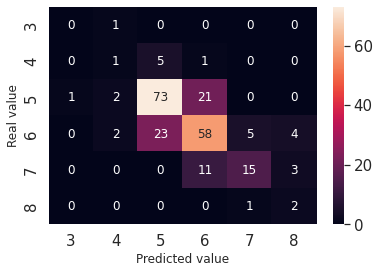

In [ ]:
# RandomForesClassifier
rfc_params = {
    "max_depth": 10,
    "max_features": 8,
    "min_samples_leaf": 1,
    "n_estimators": 500,
}
rfc = RandomForestClassifier(random_state=1)  # , **rfc_params)
rfc.fit(X2_train, y2_train)
y_preds = rfc.predict(X_test)

print("accuracy", accuracy_score(y_test, y_preds))
print("f1_score", f1_score(y_test, y_preds, average="macro"))
print("log_loss", log_loss(y_test, rfc.predict_proba(X_test)))

rep_df = rep_df.append(
    {
        "Type": "RFC2",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
rep_df2 = rep_df2.append(
    {
        "DsType": "SMOTE",
        "Model": "RFC",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
draw_cm(y_test, y_preds)


accuracy 0.5851528384279476
f1_score 0.3582360830608316
log_loss 1.0115232863605803


X has feature names, but SGDClassifier was fitted without feature names
X has feature names, but SGDClassifier was fitted without feature names


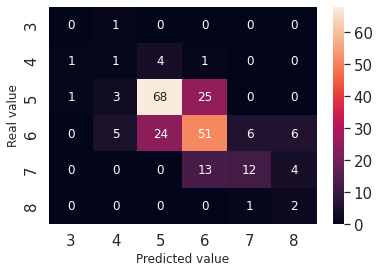

In [ ]:
# XGBClassifier
xgb_params = {
    "booster": "gbtree",
    "learning_rate": 0.01,
    "max_depth": 9,
    "n_estimators": 200,
}
xgb = XGBClassifier(random_state=1)  # , **xgb_params)
xgb.fit(X2_train, y2_train)
y_preds = xgb.predict(X_test)

print("accuracy", accuracy_score(y_test, y_preds))
print("f1_score", f1_score(y_test, y_preds, average="macro"))
print("log_loss", log_loss(y_test, xgb.predict_proba(X_test)))

rep_df = rep_df.append(
    {
        "Type": "XGB2",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
rep_df2 = rep_df2.append(
    {
        "DsType": "SMOTE",
        "Model": "XGB",
        "Accuracy": accuracy_score(y_test, y_preds),
        "F1-score": f1_score(y_test, y_preds, average="macro"),
        "Log-Loss": log_loss(y_test, sgd.predict_proba(X_test)),
    },
    ignore_index=True,
)
draw_cm(y_test, y_preds)


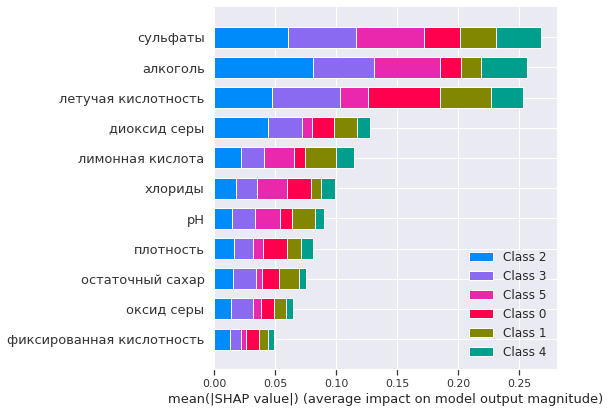

In [ ]:
#Влияние показателей на качество, сбалансированный датасет
shap.initjs()
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=X_test, max_display=50, title='Feature importance')


**Сравнение моделей:**

После применения Oversampling редких классов получилось улучшить прежнее качество.

XGBoost accuracy 0.64 (до) vs RandomForestClassifier accuracy 0.65 (после)